Striker payoff matrix: [[0.   0.8  0.7 ]
 [0.9  0.   0.2 ]
 [0.75 0.45 0.  ]]
GK payoff matrix:[[-0.   -0.9  -0.75]
 [-0.8  -0.   -0.45]
 [-0.7  -0.2  -0.  ]]
Replicator dynamics equilibrium points striker: [0.5027027  0.42162162 0.07567568]
Replicator dynamics equilibrium points GK: [0.41621622 0.27567568 0.30810811]
Striker initial condition: [0.512 0.427 0.061]
GK initial condition: [0.433 0.273 0.294]


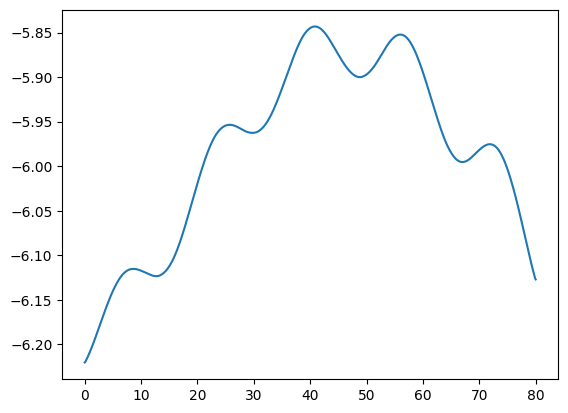

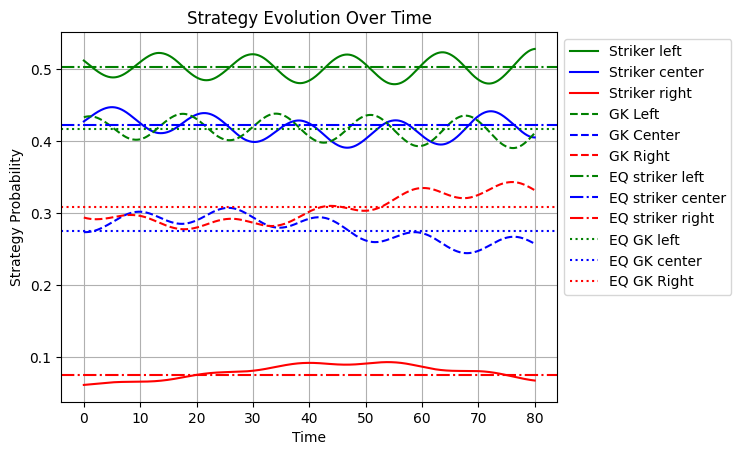

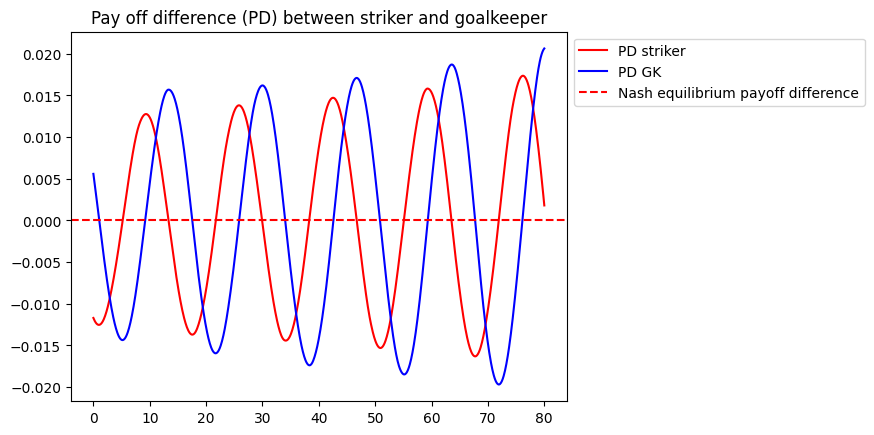

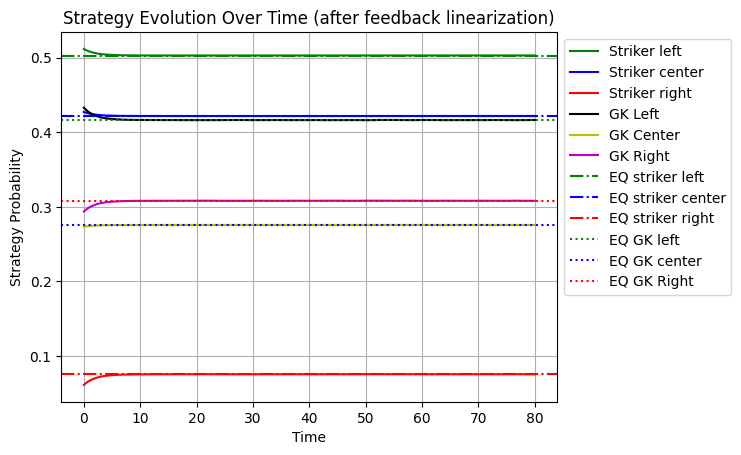

In [ ]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


## Setting the game between the striker and the goalie and finding the Nash equilibrium
# Payoff matrix values, mostly arbitrary (if not 1, it means the process is stochastic, meaning the striker can miss even if the GK moves the wrong way or maybe the GK uses a body part to potentially save it)
a1=0.8
a2=0.7
a3=0.9
a4=0.2
a5=0.75
a6=0.45
b1=0
b2=0
b3=0

# zero-sum non cooperative game between striker and goalkeeper
A=np.array([[b1,a1,a2],[a3,b2,a4],[a5,a6,b3]]) #Striker payoff Matrix
B=-A.T # GK payoff matrix, shows that this game is a zero sum game between the player and the keeper

print(f'Striker payoff matrix: {A}')
print(f'GK payoff matrix:{B}')
def replicator_dynamics(z):
    x=np.array(z[0:3]) #Striker strategy set
    x=np.reshape(x,(3,1))
    y=np.array(z[3:6]) #GK strategy set
    y=np.reshape(y,(3,1))
    dxdt=np.zeros(shape=(3,1)) # Striker replicator dynamics
    dydt=np.zeros(shape=(3,1))
  

    # x and y are column vectors

    Ay=np.matmul(A,y) # strriker payoff matrix
    phi=np.matmul(x.T,Ay) # expected value for the striker, average payoff
    Bx=np.matmul(B,x)
    phi_2=np.matmul(y.T,Bx)

    for i in range(0,3):
        dxdt[i]=x[i]*(Ay[i]-phi[0,0])
        dydt[i]=y[i]*(Bx[i]-phi_2[0,0])

    return np.concatenate((dxdt,dydt),axis=None)
# print(replicator_dynamics(z=[0.45,0.05,0.5,0.3,0.6,0.1]))
x0=np.array([0.33,0.34,0.33,0.33,0.34,0.33])

EQ_pts= fsolve(replicator_dynamics,x0=x0) #find the equilibrium point of the replicator dynamics
print(f"Replicator dynamics equilibrium points striker: {np.array([EQ_pts[0],EQ_pts[1],EQ_pts[2]])}")
print(f"Replicator dynamics equilibrium points GK: {np.array([EQ_pts[3],EQ_pts[4],EQ_pts[5]])}")



# since the game is non-cooperative, it means that there is at least one Nash equilibrium as proved by Nash


def replicator_dynamics_time(t,z):
    x=np.array(z[0:3]) #Striker strategy set
    x=np.reshape(x,(3,1))
    y=np.array(z[3:6]) #GK strategy set
    y=np.reshape(y,(3,1))
    dxdt=np.zeros(shape=(3,1)) # Striker replicator dynamics
    dydt=np.zeros(shape=(3,1))
  

    # x and y are column vectors

    Ay=np.matmul(A,y) # strriker payoff matrix
    phi=np.matmul(x.T,Ay) # expected value for the striker, average payoff
    Bx=np.matmul(B,x)
    phi_2=np.matmul(y.T,Bx)


    for i in range(0,3):
        dxdt[i]=x[i]*(Ay[i]-phi[0,0])
        dydt[i]=y[i]*(Bx[i]-phi_2[0,0])
    ew= np.concatenate((dxdt,dydt),axis=None)

    
    return ew

# setting initial conditions close to the equilibrium points to check for perturbations and stability type

xx=0.02 #standard distribution of the Gaussian noise, essentially how wide it is

noise=np.random.normal(loc=0,scale=xx,size=len(EQ_pts[0:3]))
noisydit=EQ_pts[0:3]+noise
noisydit=noisydit/np.sum(noisydit)
noisydit=np.clip(noisydit,0,1)
noisydit=noisydit/np.sum(noisydit)
print(f'Striker initial condition: {np.round(noisydit,decimals=3)}')

noise_GK=np.random.normal(loc=0,scale=xx,size=len(EQ_pts[3:6]))
noisydit_GK=EQ_pts[3:6]+noise_GK
noisydit_GK=noisydit_GK/np.sum(noisydit_GK)
noisydit_GK=np.clip(noisydit_GK,0,1)
noisydit_GK=noisydit_GK/np.sum(noisydit_GK)
print(f'GK initial condition: {np.round(noisydit_GK,decimals=3)}')

noisydit_tot=np.concatenate((noisydit,noisydit_GK),axis=None)
soln=solve_ivp(replicator_dynamics_time,t_span=(0,100),y0=noisydit_tot,t_eval=np.linspace(0,80,1000))

soln_n = soln.y.copy()
for i in range(soln_n.shape[1]):
    # Normalize striker strategy (first 3 rows)
    striker_sum = np.sum(soln_n[0:3, i])
    soln_n[0:3, i] /= striker_sum if striker_sum != 0 else 1

    # Normalize GK strategy (next 3 rows)
    gk_sum = np.sum(soln_n[3:6, i])
    soln_n[3:6, i] /= gk_sum if gk_sum != 0 else 1


# Plotting the KL divergence since it is the Lyapunov candidate
V=[]
dvdt=[]
for i in range(len(EQ_pts)):
    v=EQ_pts[i]*np.log(EQ_pts[i]/soln_n[i])
    V.append(v)
    vdot=np.gradient(v,soln_n[i])
    dvdt.append(vdot)

VKL=np.sum(V,axis=0)
dvdt=np.sum(dvdt,axis=0)
plt.plot(soln.t,VKL)
plt.show()


#plotting the results of the replicator dynamics
plt.plot(soln.t,soln_n[0],color='g',label='Striker left')
plt.plot(soln.t,soln_n[1],color='b',label='Striker center')
plt.plot(soln.t,soln_n[2],color='r',label='Striker right')

plt.plot(soln.t, soln_n[3], label='GK Left', linestyle='--', color='g')
plt.plot(soln.t, soln_n[4], label='GK Center', linestyle='--', color='b')
plt.plot(soln.t, soln_n[5], label='GK Right', linestyle='--', color='r')

plt.axhline(EQ_pts[0],color='g',label='EQ striker left',linestyle='-.')
plt.axhline(EQ_pts[1],color='b',label='EQ striker center',linestyle='-.')
plt.axhline(EQ_pts[2],color='r',label='EQ striker right',linestyle='-.')
plt.axhline(EQ_pts[3],color='g',label='EQ GK left',linestyle=':')
plt.axhline(EQ_pts[4],color='b',label='EQ GK center',linestyle=':')
plt.axhline(EQ_pts[5],color='r',label='EQ GK Right',linestyle=':')


plt.xlabel("Time")
plt.ylabel("Strategy Probability")
plt.title("Strategy Evolution Over Time")
plt.legend(bbox_to_anchor=(1,1),loc='best')
plt.grid()
plt.show()

# # calculating payoffs for the players and plotting them over time
striker_strats=soln.y[0:3]
gk_strats=soln.y[3:6]

Ay=np.matmul(A,np.array(gk_strats))
striker_payoff=np.matmul(striker_strats.T,Ay)

Bx=np.matmul(B,np.array(striker_strats))
gk_payoff=np.matmul(gk_strats.T,Bx)

plt.plot(soln.t,Ay[0]-striker_payoff[0],label='PD striker',color='r')
plt.plot(soln.t,Bx[0]-gk_payoff[0],label='PD GK',color='b')


plt.title('Pay off difference (PD) between striker and goalkeeper')

plt.axhline(0,color='r',linestyle='--',label='Nash equilibrium payoff difference')
plt.legend(bbox_to_anchor=(1,1),loc='best')
plt.show()


## using Feedback Linearization to make the replicator dynamics asymptotically stable

def feedback_linearization(t,z):
    dxdt_controlled=-0.5*(z-EQ_pts)
    return dxdt_controlled

soln=solve_ivp(feedback_linearization,t_span=(0,100),y0=noisydit_tot,t_eval=np.linspace(0,80,1000))
plt.plot(soln.t,soln.y[0],color='g',label='Striker left')
plt.plot(soln.t,soln.y[1],color='b',label='Striker center')
plt.plot(soln.t,soln.y[2],color='r',label='Striker right')

plt.plot(soln.t, soln.y[3], label='GK Left', color='k')
plt.plot(soln.t, soln.y[4], label='GK Center', color='y')
plt.plot(soln.t, soln.y[5], label='GK Right', color='m')

plt.axhline(EQ_pts[0],color='g',label='EQ striker left',linestyle='-.')
plt.axhline(EQ_pts[1],color='b',label='EQ striker center',linestyle='-.')
plt.axhline(EQ_pts[2],color='r',label='EQ striker right',linestyle='-.')
plt.axhline(EQ_pts[3],color='g',label='EQ GK left',linestyle=':')
plt.axhline(EQ_pts[4],color='b',label='EQ GK center',linestyle=':')
plt.axhline(EQ_pts[5],color='r',label='EQ GK Right',linestyle=':')


plt.xlabel("Time")
plt.ylabel("Strategy Probability")
plt.title("Strategy Evolution Over Time (after feedback linearization)")
plt.legend(bbox_to_anchor=(1,1),loc='best')
plt.grid()
plt.show()


In [31]:
# examining if the Equilibrium obatained was a nash or not:

# striker
Aystar=np.matmul(A,np.array(EQ_pts[3:6]))
RHS_S=np.matmul(np.array(EQ_pts[0:3]).T,Aystar)
print(f'payoff difference striker: {Aystar-RHS_S}')

#Goalkeeper
Bxstar=np.matmul(B,np.array(EQ_pts[0:3]))
RHS_G=np.matmul(np.array(EQ_pts[3:6]),Bxstar)
print(f'Payoff difference GK: {Bxstar-RHS_G}')


A_transpose=A.T
#checking if A is symmetric,
if np.array_equal(A,A_transpose): 
    print('A is symmetric')
else:
    A_s=0.5*(A+A.T) #averaging the matrix as shown in Wolfram Alpha research
    A_s_t=A_s.T
    if np.array_equal(A_s,A_s_t):
        print(f'Symmetrized Matrix: {A_s}')
    else:
        print('Leclerc screaming NOOOO: https://www.youtube.com/watch?v=fIslQwko340')
    


payoff difference striker: [ 4.54802862e-13 -4.91767738e-12  2.43779441e-11]
Payoff difference GK: [-2.49383847e-12  1.00476294e-11 -5.62100366e-12]
Symmetrized Matrix: [[0.    0.85  0.725]
 [0.85  0.    0.325]
 [0.725 0.325 0.   ]]
